In [193]:
import qutip as qt
import scqubits as scq
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

In [194]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.48,
                               cutoff = 110)

levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals))

A = 0.1
drive_op = n_op_energy_basis

omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+1.07838756e-17j 0.-5.20410568e-02j 0.-2.22638797e-01j
  0.-4.17687013e-01j 0.+4.24825374e-03j 0.-6.28748958e-02j]
 [0.+5.20410568e-02j 0.+9.84031091e-18j 0.+4.79485882e-01j
  0.-1.96197879e-01j 0.+7.39313106e-02j 0.+4.39799450e-02j]
 [0.+2.22638797e-01j 0.-4.79485882e-01j 0.-1.27968001e-18j
  0.+3.81301831e-01j 0.+4.30026592e-02j 0.-3.94097180e-02j]
 [0.+4.17687013e-01j 0.+1.96197879e-01j 0.-3.81301831e-01j
  0.-8.48860976e-19j 0.+4.75808155e-01j 0.+3.37475799e-01j]
 [0.-4.24825374e-03j 0.-7.39313106e-02j 0.-4.30026592e-02j
  0.-4.75808155e-01j 0.-8.66756086e-19j 0.-2.48046232e-01j]
 [0.+6.28748958e-02j 0.-4.39799450e-02j 0.+3.94097180e-02j
  0.-3.37475799e-01j 0.+2.48046232e-01j 0.-2.77347866e-17j]]

In [195]:
is_hermitian = drive_op.isherm
print("drive_op is Hermitian:", is_hermitian)

drive_op is Hermitian: True


In [196]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [197]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

### times defined

In [198]:
times = np.linspace(500, 700, 10000)

# options = qt.Options(nsteps=1000000, store_states=True, atol=1e-8, rtol=1e-6)
options = qt.Options(nsteps=1000000, store_states=True)


result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0010004043579101562
    preparation time: 0.0
    run time: 0.36953067779541016
    solver: 'Schrodinger Evolution'
  Time interval: [500.0, 700.0] (10000 steps)
  Number of e_ops: 6
  States saved.
>

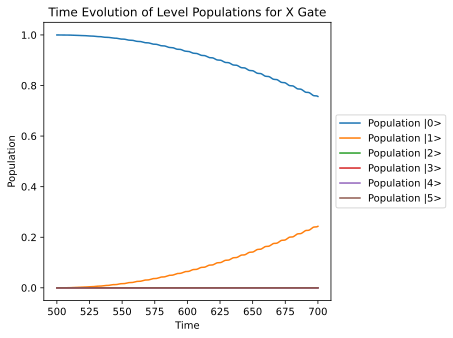

In [199]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Time Evolution of Level Populations for X Gate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Timing

In [200]:
d01 = abs(n_op_energy_basis[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

603.6757989431644

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

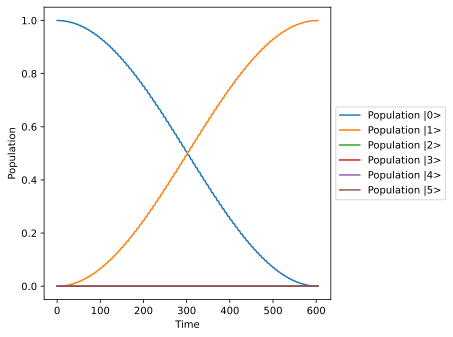

In [201]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Fidelity

In [202]:
X_ideal = qt.sigmax()

X_ideal

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [203]:
U = qt.propagator(H, tx, args=args, options=options)

U

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.10388939e-02+2.58298502e-04j  2.12029444e-01-9.77181428e-01j
  -3.55562451e-03-2.26581256e-03j  4.43756408e-03-2.53185827e-04j
  -4.21274837e-04-1.54520588e-04j -5.41414857e-04-7.65990721e-05j]
 [ 3.06916619e-01+9.51645066e-01j -1.09388536e-02+1.35107792e-03j
  -6.07819226e-03+3.39692808e-03j -1.79052499e-03+7.05867165e-04j
   2.60712331e-04-2.96064379e-04j -1.02224109e-04+7.81803276e-05j]
 [-6.25771344e-03+2.95530038e-03j  2.33098707e-03-3.58717433e-03j
   5.91680972e-01+8.05892495e-01j -7.07964539e-04-6.15749526e-03j
   7.88214164e-04-6.08684498e-04j -7.57601569e-04+2.85711469e-04j]
 [-1.93115241e-03+3.25949665e-04j -4.43757145e-03-1.47660304e-04j
   4.28107607e-03+4.45577179e-03j  2.47670253e-01+9.67771916e-01j
   1.54282189e-02-8.77512390e-03j  1.10336176e-02-1.64749213e-03j]
 [-3.94962341e-04+8.38839357e-05j -2.84865749e-04+3.19837982e-04j
  -6.96730912e-04+7.96679702e-04j -1.500

Calculating propagators...


Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 23899.44it/s]


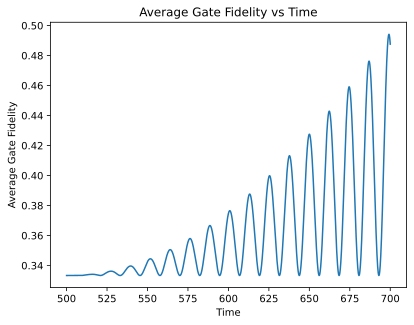

In [204]:
iterations = 10000

print("Calculating propagators...")
P_list = qt.propagator(H, times, args=args, options=options)

fid_times = []
fid_values = []
for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    U_t = P_list[i]
    U_2lvl = qt.Qobj(U_t.full()[:2, :2])
    fid = qt.average_gate_fidelity(U_2lvl, X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [205]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

tx = peak_time

Peak average gate fidelity: 0.4941483961124728
Time at peak fidelity: 699.1999199919992


---------------------

## Noise

### Defining gamma

In [206]:
gamma_ij = {}
for j in range(1, levels):
    for i in range(j):
        t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5)
        if t1 is not None and t1 > 0:
            rate = 1.0 / t1
            gamma_ij[(i, j)] = rate
            # gamma_ij[(j, i)] = rate  
gamma_ij

{(0, 1): 1.0105150256036662e-05,
 (0, 2): 0.00012457805723540096,
 (1, 2): 0.0005778185878582614,
 (0, 3): 0.00043847193831442877,
 (1, 3): 9.674498864173898e-05,
 (2, 3): 0.0003654648737811229,
 (0, 4): 4.5358716542010955e-08,
 (1, 4): 1.373715093941894e-05,
 (2, 4): 4.647618634468422e-06,
 (3, 4): 0.0005689889229704481,
 (0, 5): 9.935607252458312e-06,
 (1, 5): 4.8612641906153375e-06,
 (2, 5): 3.903431069544427e-06,
 (3, 5): 0.00028623658100727125,
 (4, 5): 0.00016702026913130086}

### Defining c_ops

In [207]:
c_ops = []
for (i, j), gamma in gamma_ij.items():
    # |i><j| operator
    cop = (np.sqrt(gamma)) * qt.basis(levels, i) * qt.basis(levels, j).dag()
    c_ops.append(cop)

c_ops

[Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=False
 Qobj data =
 [[0.         0.00317886 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]],
 Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=False
 Qobj data =
 [[0.         0.         0.01116145 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.     

### Calculating the list of propagators

In [ ]:
# times = np.linspace(0, 1000, iterations)

print("Calculating propagators...")
P_list = qt.propagator(H, times, c_ops=c_ops, args=args, options=options)

P_list

Calculating propagators...


[Quantum object: dims=[[[6], [6]], [[6], [6]]], shape=(36, 36), type='super', dtype=Dense, isherm=False
 Qobj data =
 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]],
 Quantum object: dims=[[[6], [6]], [[6], [6]]], shape=(36, 36), type='super', dtype=Dense, isherm=False
 Qobj data =
 [[ 9.99999709e-01-1.25920354e-24j  5.86319772e-05-2.98960694e-07j
    2.49361045e-04-2.35887425e-05j ...  3.13168699e-08+1.84862917e-09j
   -3.72134450e-10-3.41451075e-12j  2.03704790e-07+3.41881428e-26j]
  [-5.85973049e-05+3.00016007e-07j  9.99947367e-01-1.02183016e-02j
   -5.36637788e-04+5.35244892e-05j ...  1.54904824e-08+8.19149590e-10j
   -5.83269731e-09-2.91304022e-11j -3.47357787e-09+1.79767363e-11j]
  [-2.49185380e-04+2.36800394e-05j  5.36690952e-04-5.37773173e-05j
    9.82173904e-01-1.87933664e-01j ... -3.01844211e-08+1.11186042e-09j
   -3.38517224e-09+2.87163769e-10j  3.09246244e-09-2

In [210]:
# P_list_kraus = [qt.to_kraus(k) for k in P_list]

# P_list_kraus

In [211]:
def sanitize_superoperator(S, threshold=1e-12):

    # Step 3: Sanitize Choi matrix
    choi_mat = S.full()
    eigvals, eigvecs = np.linalg.eigh(choi_mat)
    eigvals_sanitized = np.clip(eigvals, 0, None)  # Small negatives to zero
    choi_sanitized = eigvecs @ np.diag(eigvals_sanitized) @ eigvecs.conj().T
    S_sanitized = qt.Qobj(choi_sanitized, dims=S.dims, superrep='choi')
    return S_sanitized

P_list_kraus = []
for S in P_list:
    S_san = sanitize_superoperator(S)
    kraus_ops = qt.to_kraus(S_san, tol=1e-16)
    P_list_kraus.append(kraus_ops)


 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\core\superop_reps.py: 133

In [212]:
len(P_list_kraus)

10000

In [213]:
P_list_2x2 = [qt.Qobj(U[0].full()[:2, :2]) for U in P_list_kraus]

In [214]:
P_list_2x2_super = [qt.to_super(k) for k in P_list_2x2]

P_list_2x2_super

[Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=True
 Qobj data =
 [[1. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]],
 Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
 Qobj data =
 [[ 1.79318528e-06+0.00000000e+00j -7.34419507e-07+1.75009834e-07j
   -7.34419507e-07-1.75009834e-07j  3.17870362e-07+3.14199174e-24j]
  [-7.34398966e-07-1.75024942e-07j -2.59484823e-08+1.84502932e-11j
    2.83699540e-07+1.43358735e-07j  1.06292979e-08+2.52494228e-09j]
  [-7.34398966e-07+1.75024942e-07j  2.83699540e-07-1.43358735e-07j
   -2.59484823e-08-1.84502932e-11j  1.06292979e-08-2.52494228e-09j]
  [ 3.17856485e-07-2.97132057e-25j  1.06253991e-08-2.54027375e-09j
    1.06253991e-08+2.54027375e-09j  3.75490521e-10-5.60820941e-30j]],
 Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
 Qobj data =
 [[ 3.60585889e-07+0.00000000e+00j -1.32039463e-

Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 13650.16it/s]


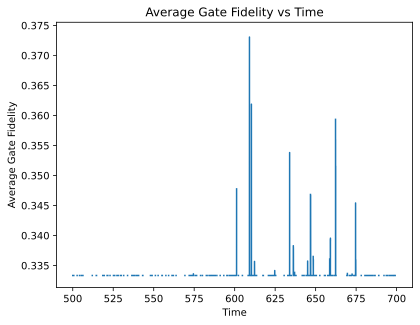

In [215]:
fid_times = []
fid_values = []

for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    U_t = P_list[i]

    #testing
    U_t = P_list_2x2_super[i]

    fid = qt.average_gate_fidelity(U_t, X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [216]:
# fid_times = []
# fid_values = []

# for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
#     U_t = P_list[i]
#     fid = qt.average_gate_fidelity(U_t, proj_op)
    
#     # fid = fid * 4

#     fid_times.append(t)
#     fid_values.append(fid)

# plt.plot(np.array(fid_times), np.array(fid_values))
# plt.xlabel('Time')
# plt.ylabel('Average Gate Fidelity')
# plt.title('Average Gate Fidelity vs Time')
# plt.show()

In [217]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

Peak average gate fidelity: nan
Time at peak fidelity: 500.1000100010001
